In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
test_batch_size=256
train_batch_size = 3000
valid_batch_size = 600

train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=valid_batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
class Encoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.BatchNorm2d(16),
            # nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 64, 128),
            nn.ReLU(True),
            nn.Linear(128, 32),
            nn.ReLU(True),
            nn.Linear(32, encoded_space_dim),
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 64),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(64, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3,
            stride=2, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2,
            padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2,
            padding=1, output_padding=1)
            # nn.BatchNorm2d(8),
            # nn.ReLU(True),
            # nn.ConvTranspose2d(8, 1, 3, stride=2,
            # padding=1, output_padding=1),
            # nn.ReLU(True),
            # nn.MaxPool2d(2, stride=2)
        )


    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.003

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 8

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=576, bias=True)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        # print(image_batch.shape)
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # print(encoded_data.shape)
        # Decode data
        decoded_data = decoder(encoded_data)
        # print(decoded_data.shape)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
### Testing function
import numpy as np
test_array = np.zeros((256,1,28,28))
test_reconstructed_array = np.zeros((256,1,28,28))

def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            # print(image_batch.detach().cpu().numpy())
            # print(image_batch.detach().cpu().numpy().shape)
            np.append(test_array, image_batch.detach().cpu().numpy(), axis=0)
            np.append(test_reconstructed_array, decoded_data.detach().cpu().numpy(), axis=0)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()


 EPOCH 1/100 	 train loss 0.2326059639453888 	 val loss 0.2329472005367279


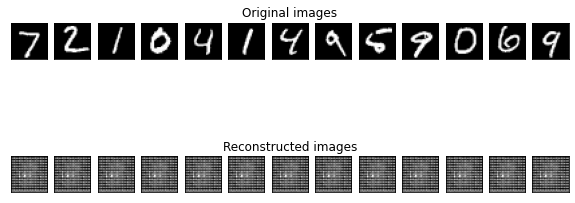


 EPOCH 2/100 	 train loss 0.14254212379455566 	 val loss 0.14866164326667786


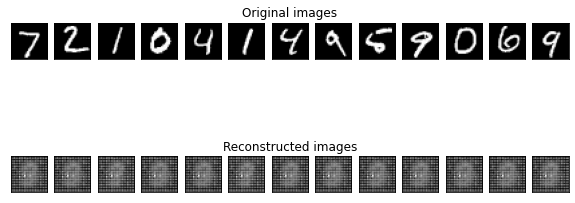


 EPOCH 3/100 	 train loss 0.09982039034366608 	 val loss 0.09307827800512314


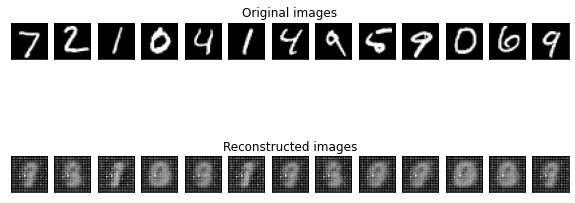


 EPOCH 4/100 	 train loss 0.07602342963218689 	 val loss 0.06799808889627457


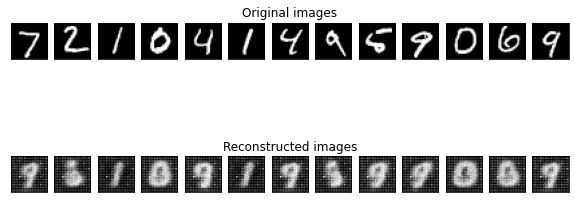


 EPOCH 5/100 	 train loss 0.06244409829378128 	 val loss 0.059662315994501114


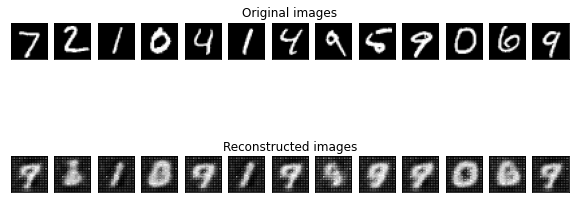


 EPOCH 6/100 	 train loss 0.054924771189689636 	 val loss 0.05217295140028


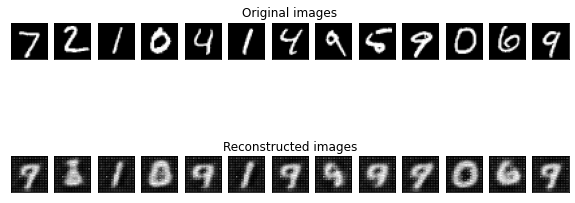


 EPOCH 7/100 	 train loss 0.0497627779841423 	 val loss 0.04848815128207207


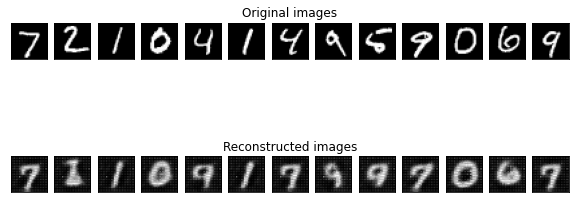


 EPOCH 8/100 	 train loss 0.046038150787353516 	 val loss 0.044170454144477844


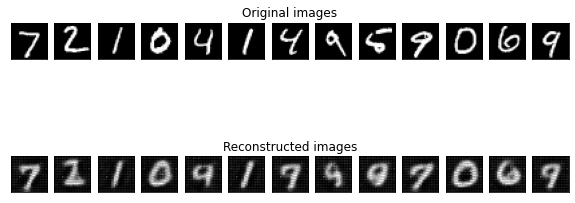


 EPOCH 9/100 	 train loss 0.04251576215028763 	 val loss 0.040536489337682724


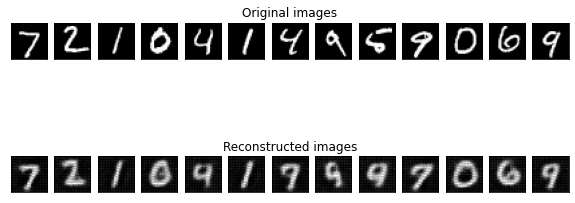


 EPOCH 10/100 	 train loss 0.03872999548912048 	 val loss 0.03707804158329964


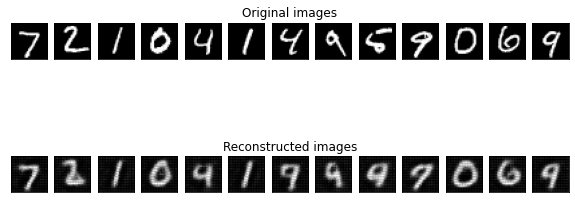


 EPOCH 11/100 	 train loss 0.036361925303936005 	 val loss 0.034743938595056534


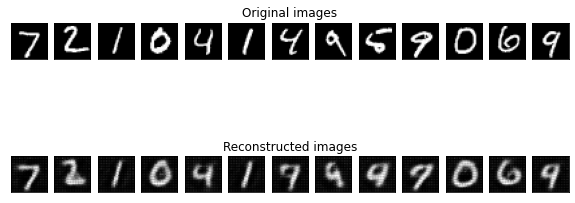


 EPOCH 12/100 	 train loss 0.03375732898712158 	 val loss 0.03281690180301666


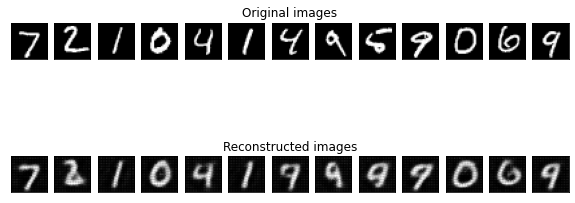


 EPOCH 13/100 	 train loss 0.032057322561740875 	 val loss 0.031185995787382126


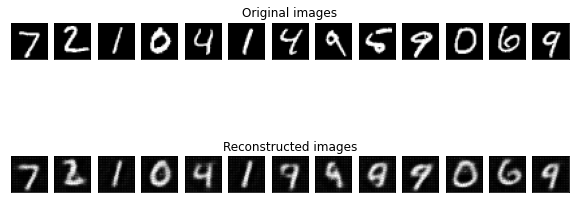


 EPOCH 14/100 	 train loss 0.03032253310084343 	 val loss 0.029562922194600105


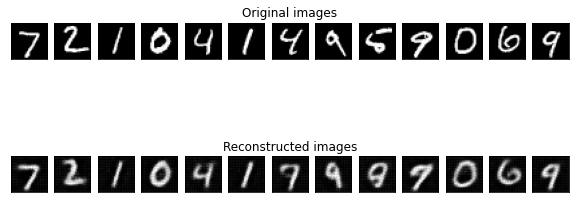


 EPOCH 15/100 	 train loss 0.028749626129865646 	 val loss 0.02834353595972061


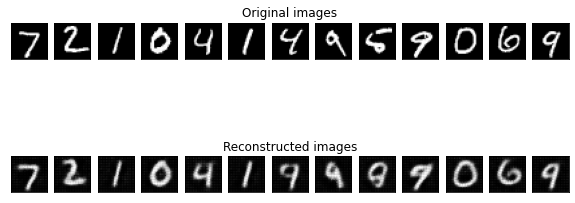


 EPOCH 16/100 	 train loss 0.027790803462266922 	 val loss 0.026929708197712898


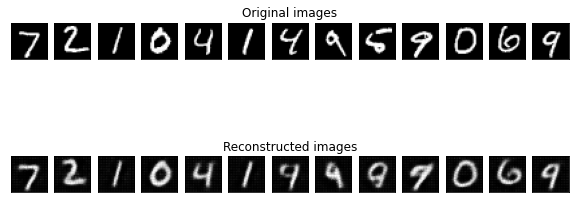


 EPOCH 17/100 	 train loss 0.027191875502467155 	 val loss 0.026591461151838303


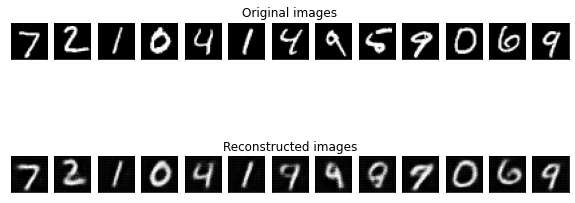


 EPOCH 18/100 	 train loss 0.025953400880098343 	 val loss 0.025046607479453087


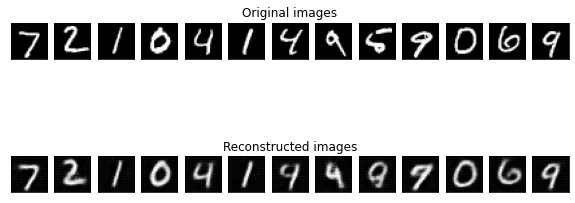


 EPOCH 19/100 	 train loss 0.025623057037591934 	 val loss 0.025328349322080612


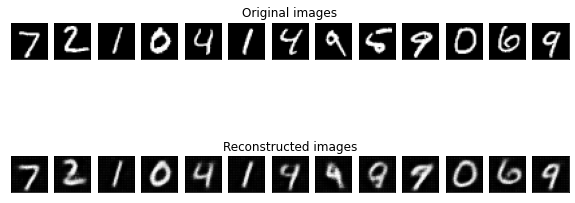


 EPOCH 20/100 	 train loss 0.024796608835458755 	 val loss 0.02550930343568325


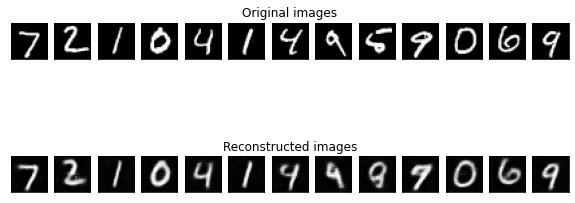


 EPOCH 21/100 	 train loss 0.024227116256952286 	 val loss 0.023768944665789604


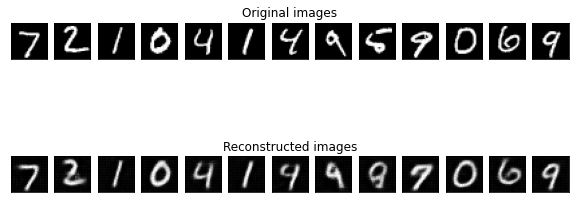


 EPOCH 22/100 	 train loss 0.023541700094938278 	 val loss 0.02456696517765522


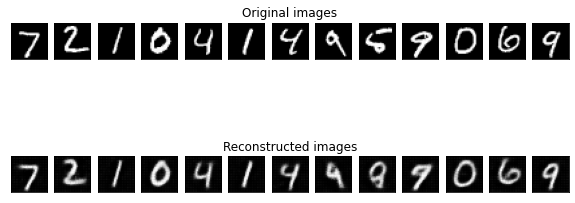


 EPOCH 23/100 	 train loss 0.023567266762256622 	 val loss 0.023066753521561623


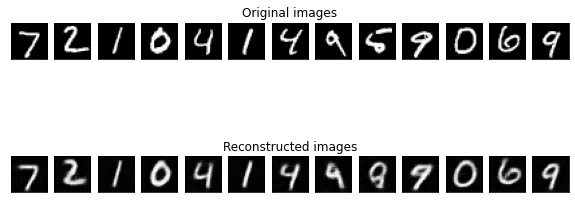


 EPOCH 24/100 	 train loss 0.022749556228518486 	 val loss 0.02285167947411537


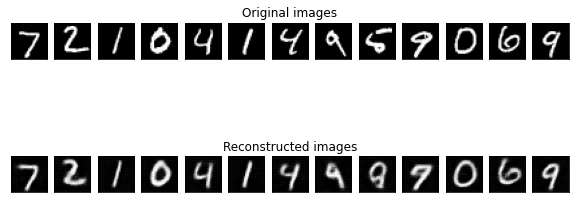


 EPOCH 25/100 	 train loss 0.02240539714694023 	 val loss 0.02190318889915943


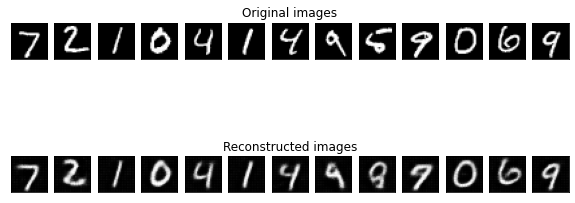


 EPOCH 26/100 	 train loss 0.022346679121255875 	 val loss 0.021644212305545807


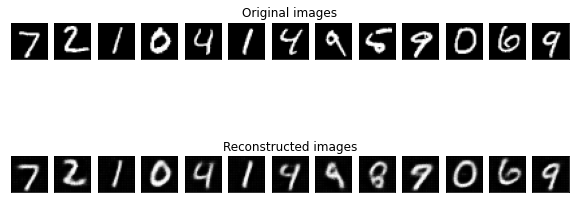


 EPOCH 27/100 	 train loss 0.021290093660354614 	 val loss 0.021381130442023277


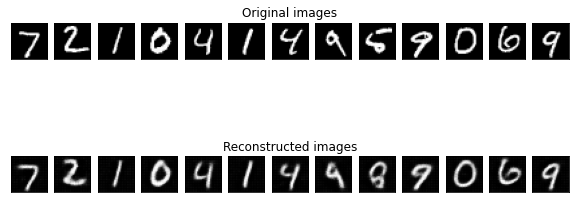


 EPOCH 28/100 	 train loss 0.020925376564264297 	 val loss 0.021108655259013176


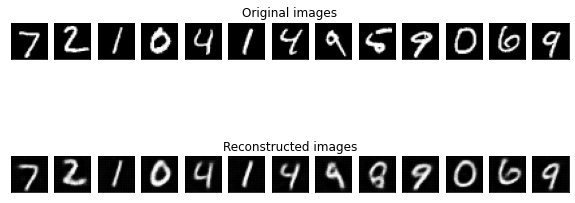


 EPOCH 29/100 	 train loss 0.020799711346626282 	 val loss 0.02066856622695923


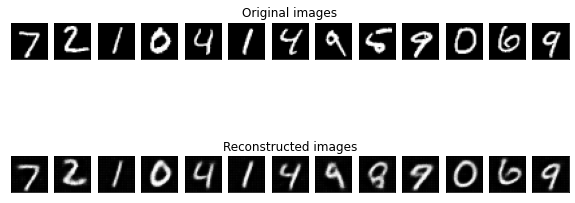


 EPOCH 30/100 	 train loss 0.020427701994776726 	 val loss 0.02049957402050495


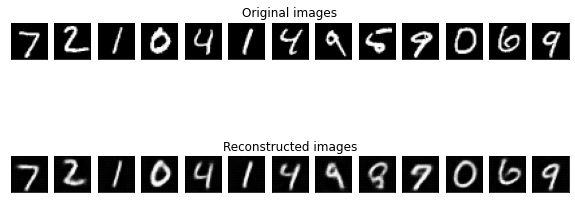


 EPOCH 31/100 	 train loss 0.020030833780765533 	 val loss 0.01971243880689144


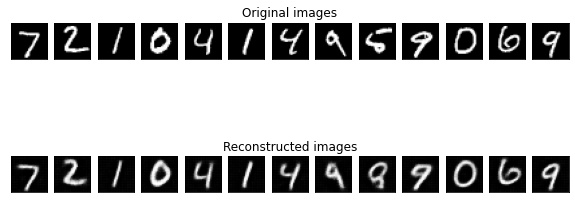


 EPOCH 32/100 	 train loss 0.019593901932239532 	 val loss 0.019937459379434586


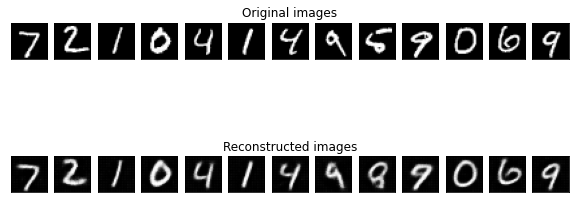


 EPOCH 33/100 	 train loss 0.020055223256349564 	 val loss 0.019297515973448753


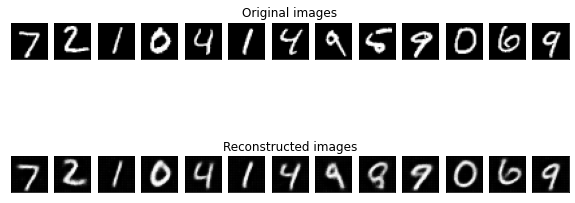


 EPOCH 34/100 	 train loss 0.019103512167930603 	 val loss 0.019681204110383987


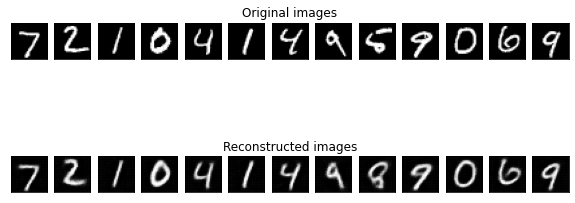


 EPOCH 35/100 	 train loss 0.018880769610404968 	 val loss 0.020748425275087357


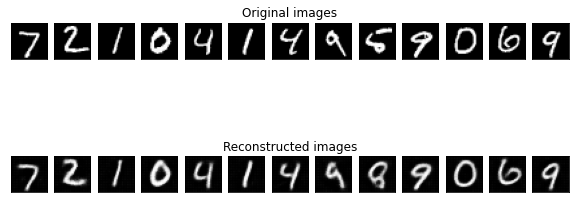


 EPOCH 36/100 	 train loss 0.019180290400981903 	 val loss 0.01869872771203518


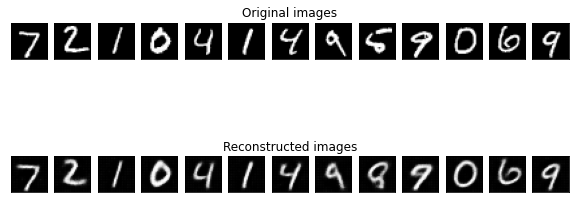


 EPOCH 37/100 	 train loss 0.019007960334420204 	 val loss 0.019038651138544083


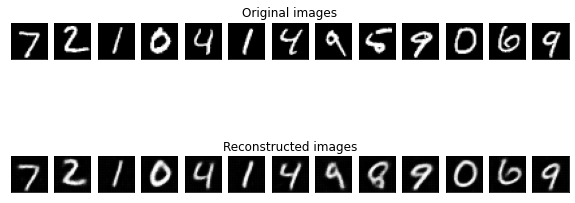


 EPOCH 38/100 	 train loss 0.018570873886346817 	 val loss 0.018373310565948486


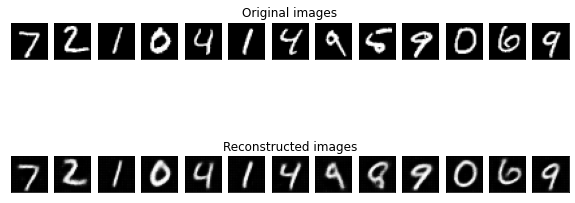


 EPOCH 39/100 	 train loss 0.018013685941696167 	 val loss 0.01798095554113388


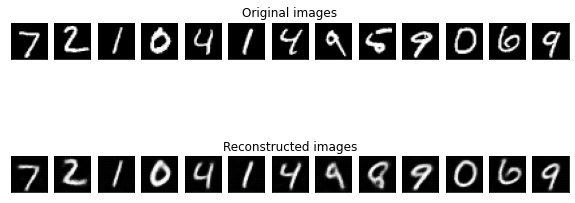


 EPOCH 40/100 	 train loss 0.018105730414390564 	 val loss 0.017991280183196068


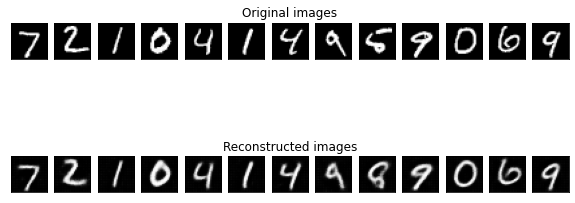


 EPOCH 41/100 	 train loss 0.017980234697461128 	 val loss 0.017919596284627914


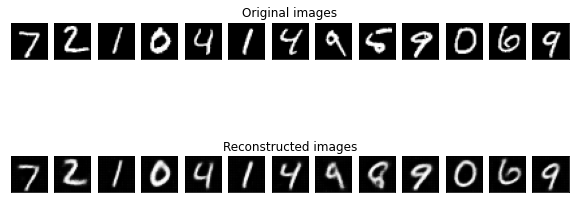


 EPOCH 42/100 	 train loss 0.01760157197713852 	 val loss 0.018047545105218887


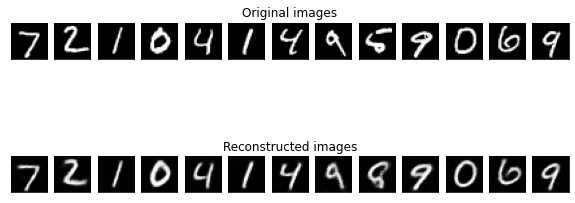


 EPOCH 43/100 	 train loss 0.017752937972545624 	 val loss 0.01813345029950142


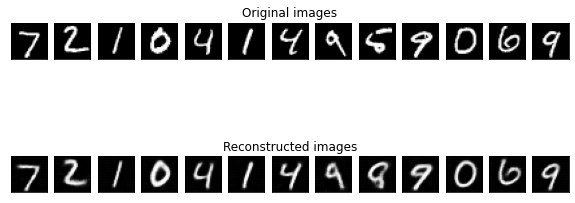


 EPOCH 44/100 	 train loss 0.017919890582561493 	 val loss 0.01804846152663231


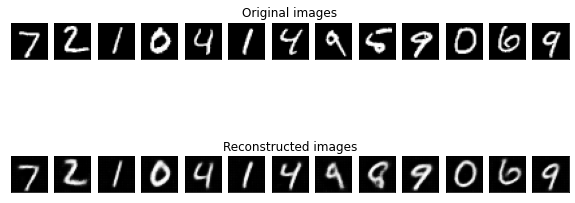


 EPOCH 45/100 	 train loss 0.017455562949180603 	 val loss 0.01711380109190941


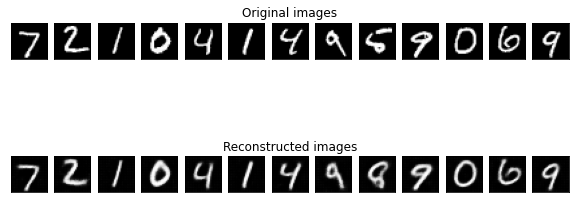


 EPOCH 46/100 	 train loss 0.017240051180124283 	 val loss 0.029994865879416466


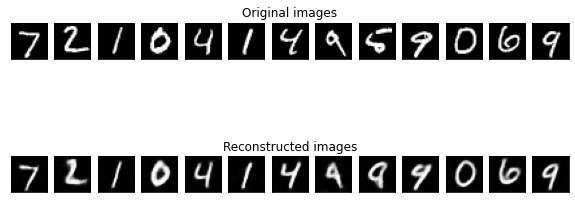


 EPOCH 47/100 	 train loss 0.02079465053975582 	 val loss 0.018350040540099144


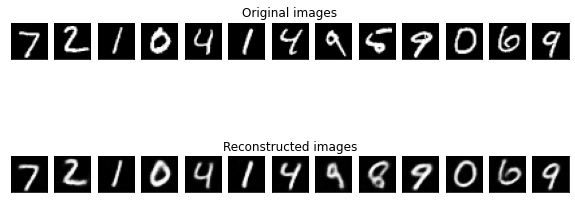


 EPOCH 48/100 	 train loss 0.017491862177848816 	 val loss 0.017259789630770683


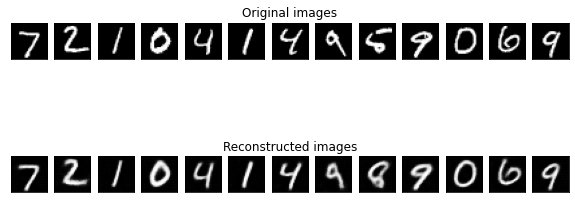


 EPOCH 49/100 	 train loss 0.01671453006565571 	 val loss 0.01677015796303749


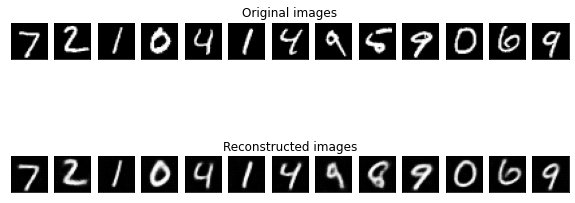


 EPOCH 50/100 	 train loss 0.01653609424829483 	 val loss 0.01782367192208767


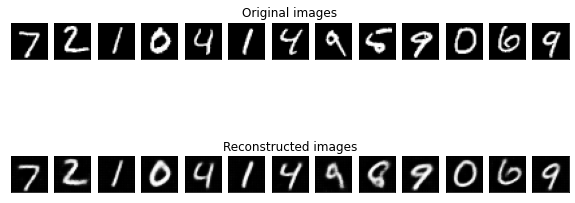


 EPOCH 51/100 	 train loss 0.016933366656303406 	 val loss 0.017103144899010658


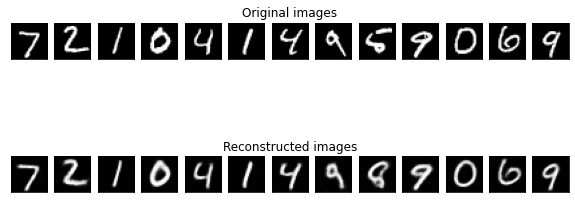


 EPOCH 52/100 	 train loss 0.01649678498506546 	 val loss 0.017271628603339195


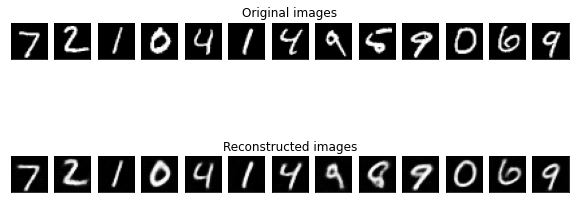


 EPOCH 53/100 	 train loss 0.01642487943172455 	 val loss 0.016504419967532158


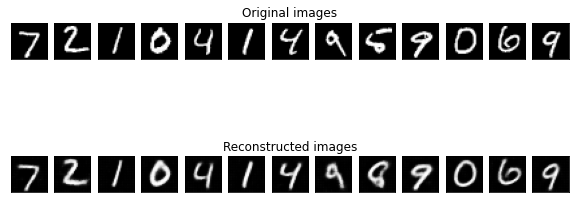


 EPOCH 54/100 	 train loss 0.017131444066762924 	 val loss 0.017220690846443176


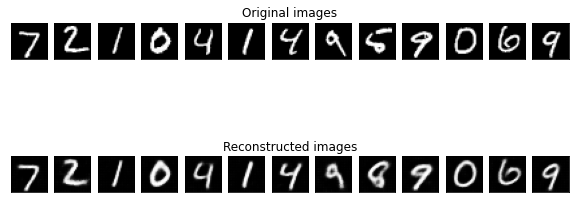


 EPOCH 55/100 	 train loss 0.016901183873414993 	 val loss 0.016735205426812172


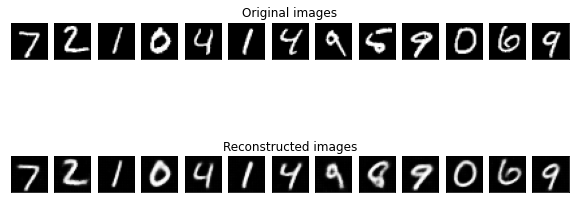


 EPOCH 56/100 	 train loss 0.016294457018375397 	 val loss 0.016338840126991272


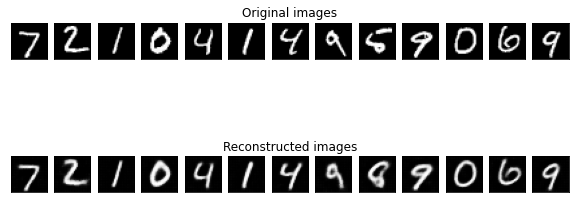


 EPOCH 57/100 	 train loss 0.01654716394841671 	 val loss 0.01690198853611946


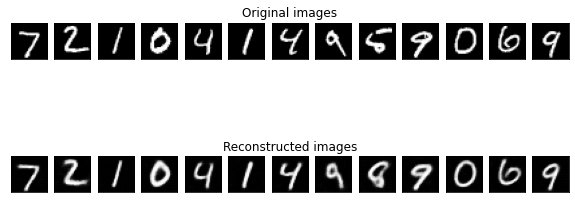


 EPOCH 58/100 	 train loss 0.016122514382004738 	 val loss 0.01648702099919319


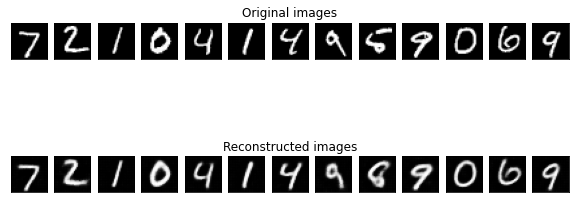


 EPOCH 59/100 	 train loss 0.015918035060167313 	 val loss 0.01674436777830124


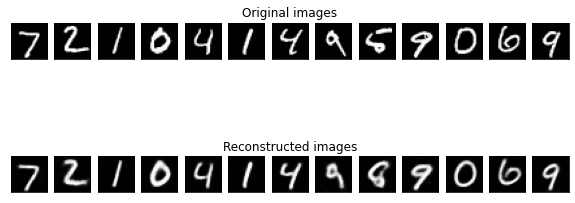


 EPOCH 60/100 	 train loss 0.016352534294128418 	 val loss 0.01641499064862728


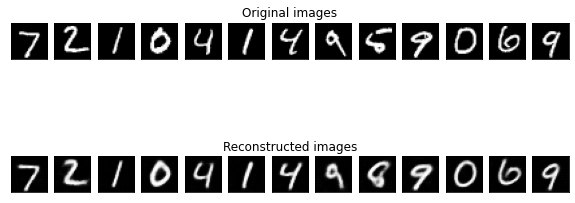


 EPOCH 61/100 	 train loss 0.015999792143702507 	 val loss 0.021941207349300385


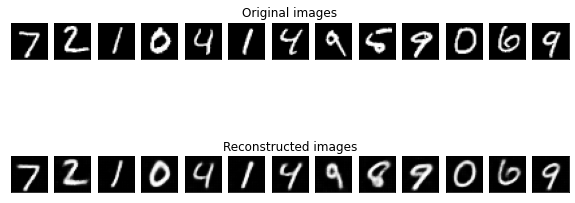


 EPOCH 62/100 	 train loss 0.02279801294207573 	 val loss 0.01937846466898918


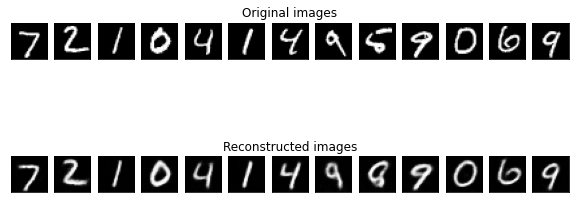


 EPOCH 63/100 	 train loss 0.017511796206235886 	 val loss 0.016672255471348763


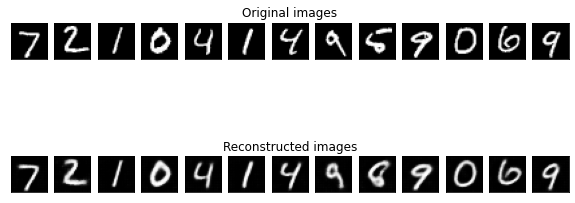


 EPOCH 64/100 	 train loss 0.016021624207496643 	 val loss 0.016136612743139267


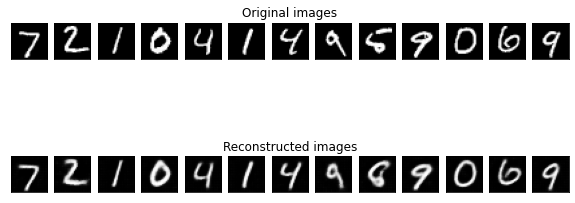


 EPOCH 65/100 	 train loss 0.015574855729937553 	 val loss 0.015807652845978737


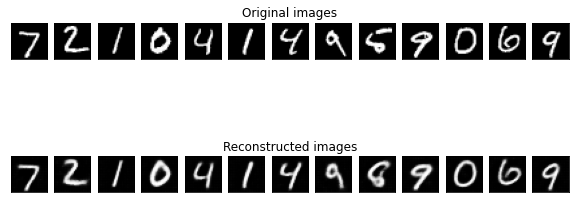


 EPOCH 66/100 	 train loss 0.01575414277613163 	 val loss 0.016006693243980408


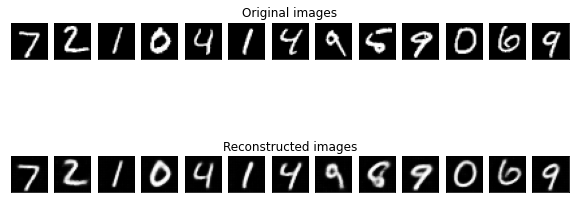


 EPOCH 67/100 	 train loss 0.015537898056209087 	 val loss 0.016028176993131638


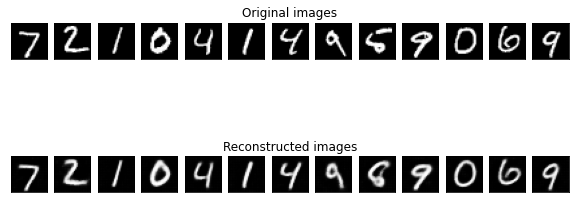


 EPOCH 68/100 	 train loss 0.015440158545970917 	 val loss 0.016122525557875633


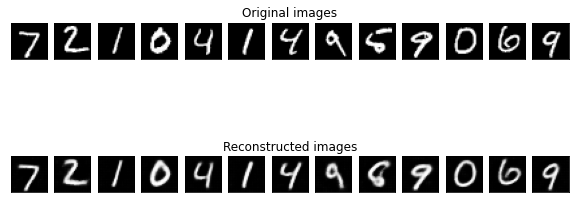


 EPOCH 69/100 	 train loss 0.017551688477396965 	 val loss 0.01682991534471512


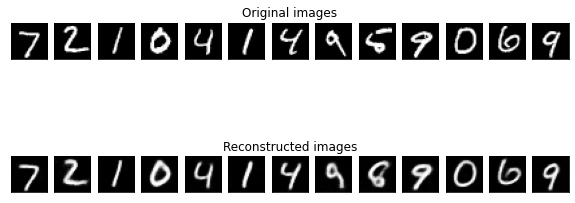


 EPOCH 70/100 	 train loss 0.015947092324495316 	 val loss 0.015682045370340347


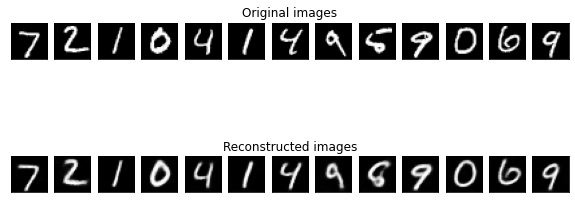


 EPOCH 71/100 	 train loss 0.01518072746694088 	 val loss 0.015799252316355705


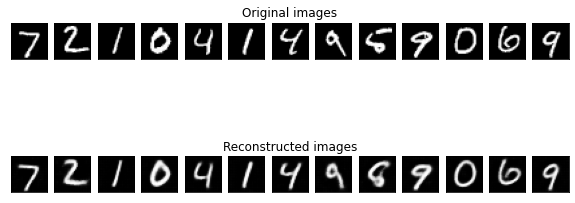


 EPOCH 72/100 	 train loss 0.015047428198158741 	 val loss 0.015847932547330856


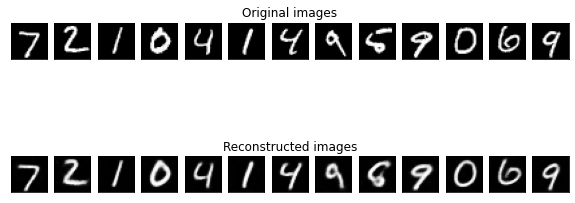


 EPOCH 73/100 	 train loss 0.015516471117734909 	 val loss 0.015448501333594322


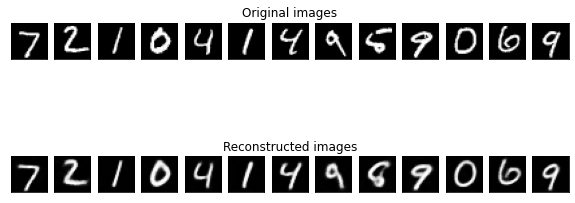


 EPOCH 74/100 	 train loss 0.015475984662771225 	 val loss 0.015582139603793621


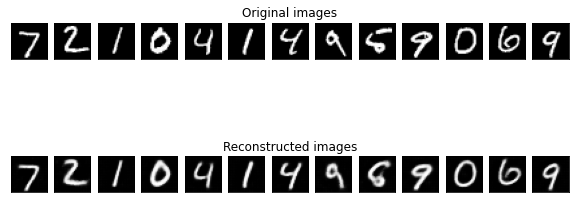


 EPOCH 75/100 	 train loss 0.01509236078709364 	 val loss 0.015521733090281487


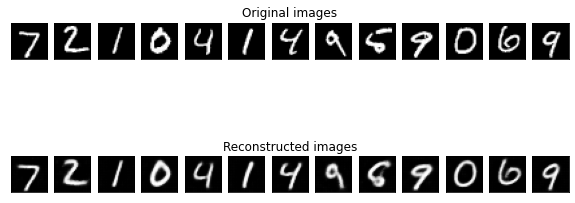


 EPOCH 76/100 	 train loss 0.015212513506412506 	 val loss 0.015558346174657345


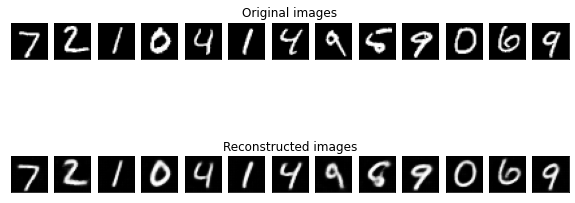


 EPOCH 77/100 	 train loss 0.015233814716339111 	 val loss 0.01584795117378235


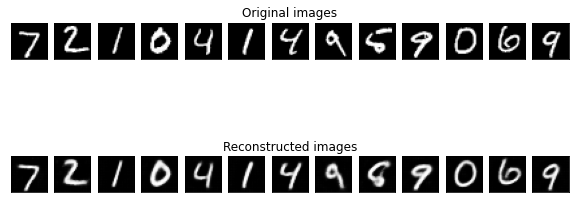


 EPOCH 78/100 	 train loss 0.015233166515827179 	 val loss 0.016244374215602875


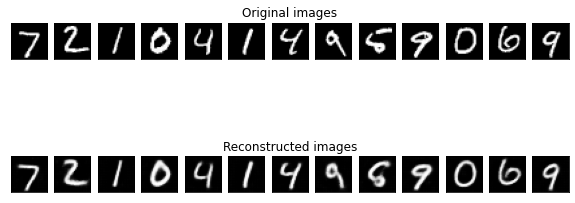


 EPOCH 79/100 	 train loss 0.015169549733400345 	 val loss 0.015544118359684944


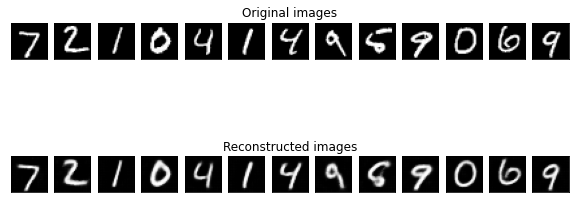


 EPOCH 80/100 	 train loss 0.014992306008934975 	 val loss 0.015554962679743767


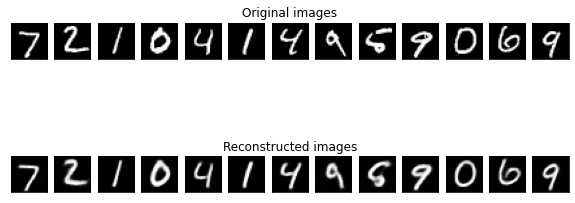


 EPOCH 81/100 	 train loss 0.015234783291816711 	 val loss 0.015280389226973057


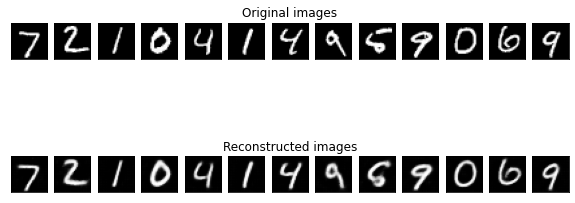


 EPOCH 82/100 	 train loss 0.015209831297397614 	 val loss 0.015384815633296967


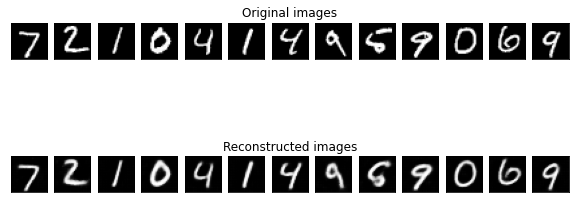


 EPOCH 83/100 	 train loss 0.01493406854569912 	 val loss 0.015489478595554829


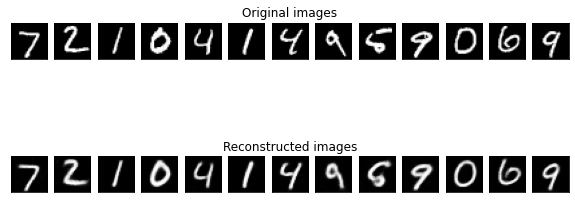


 EPOCH 84/100 	 train loss 0.015059356577694416 	 val loss 0.016046660020947456


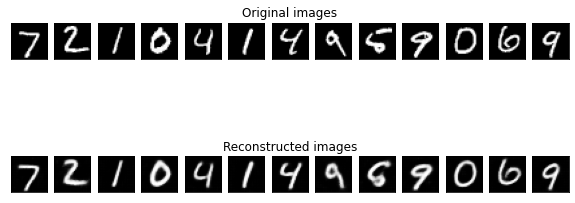


 EPOCH 85/100 	 train loss 0.015126409940421581 	 val loss 0.01609041914343834


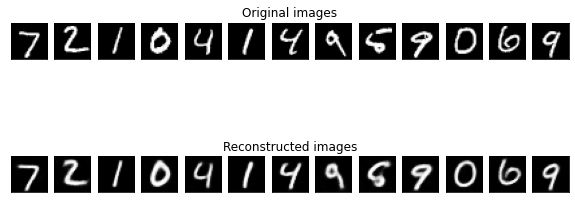


 EPOCH 86/100 	 train loss 0.015056021511554718 	 val loss 0.01535012573003769


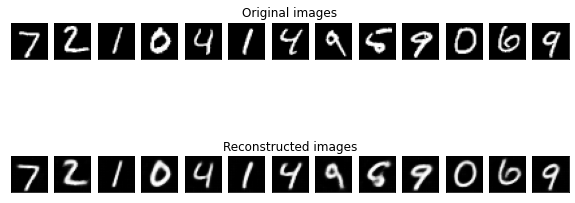


 EPOCH 87/100 	 train loss 0.014664371497929096 	 val loss 0.015240882523357868


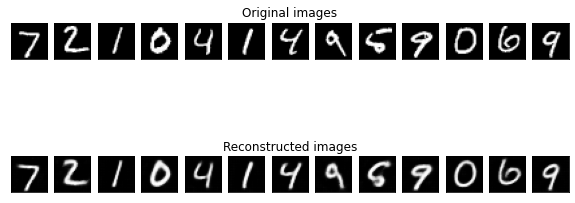


 EPOCH 88/100 	 train loss 0.014667836017906666 	 val loss 0.016061581671237946


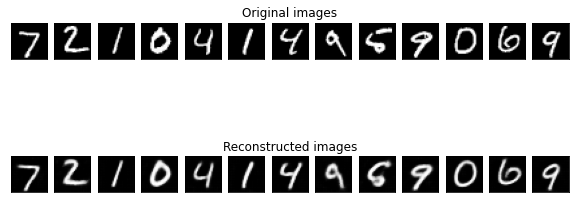


 EPOCH 89/100 	 train loss 0.015145588666200638 	 val loss 0.015385949052870274


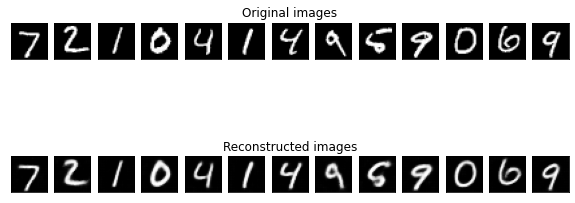


 EPOCH 90/100 	 train loss 0.014660021290183067 	 val loss 0.01486827153712511


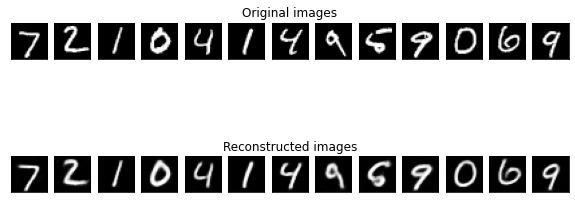


 EPOCH 91/100 	 train loss 0.015315879136323929 	 val loss 0.01812298782169819


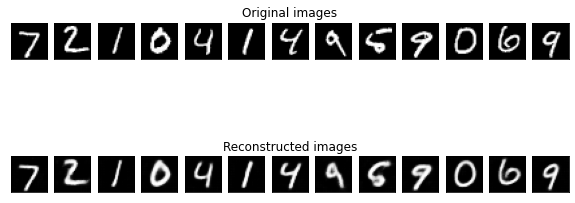


 EPOCH 92/100 	 train loss 0.0162237286567688 	 val loss 0.01573728211224079


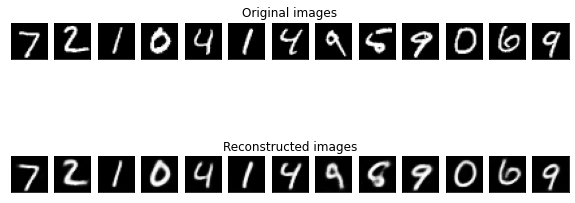


 EPOCH 93/100 	 train loss 0.014776911586523056 	 val loss 0.014919521287083626


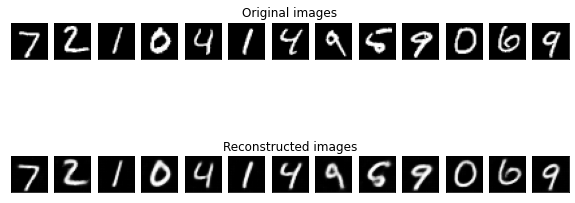


 EPOCH 94/100 	 train loss 0.01438513956964016 	 val loss 0.015197173692286015


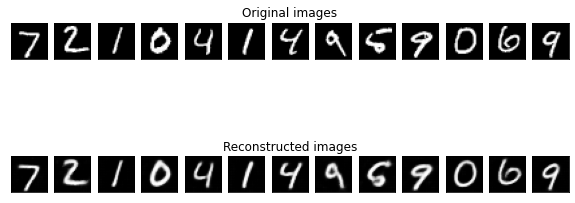


 EPOCH 95/100 	 train loss 0.014810174703598022 	 val loss 0.01590672694146633


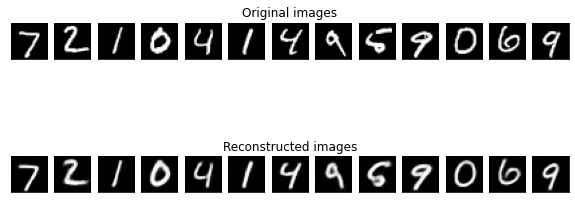


 EPOCH 96/100 	 train loss 0.015420302748680115 	 val loss 0.015336700715124607


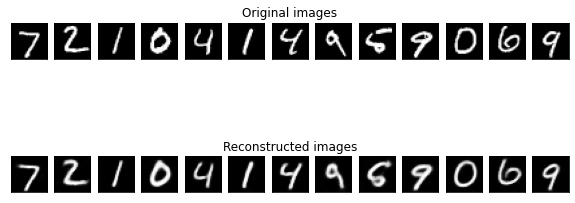


 EPOCH 97/100 	 train loss 0.01458507776260376 	 val loss 0.014848080463707447


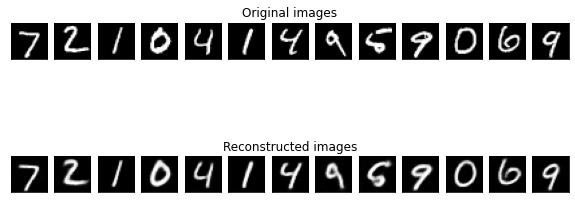


 EPOCH 98/100 	 train loss 0.014202920719981194 	 val loss 0.01470347959548235


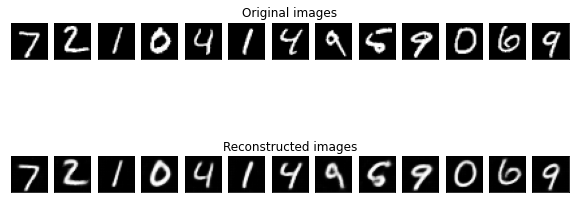


 EPOCH 99/100 	 train loss 0.014522640034556389 	 val loss 0.014756470918655396


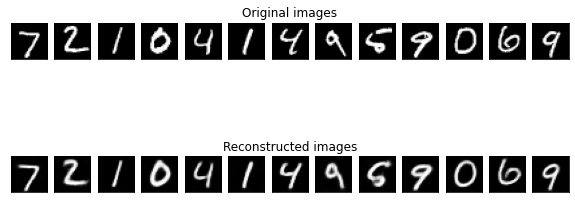


 EPOCH 100/100 	 train loss 0.014335986226797104 	 val loss 0.014850938692688942


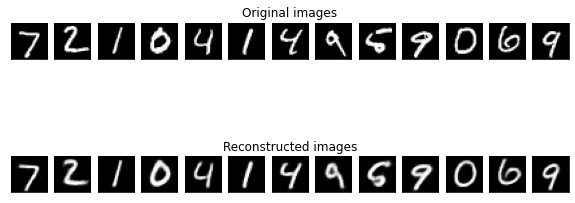

In [ ]:
num_epochs = 100
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=13)

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.014850937761366367

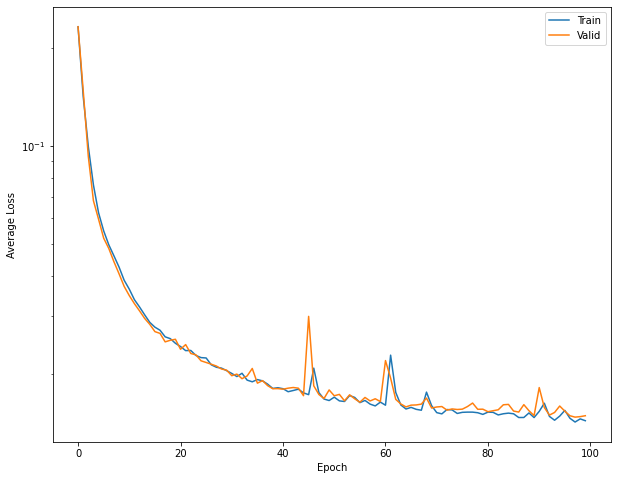

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()